
# Учебная задача NLP: классификация рецептов (RecipeNLG)

**Задача:** бинарная классификация рецептов (условно: вегетарианский / невегетарианский)  
**Датасет:** RecipeNLG (HuggingFace)  
**Фреймворк:** PyTorch + Transformers  
**Уровень:** учебный

Цель ноутбука — продемонстрировать полный NLP pipeline:
- загрузка открытого датасета;
- предобработка текста;
- обучение модели;
- оценка качества;
- выводы.


## 1. Импорт библиотек

In [10]:
import os, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback,
)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
plt.style.use("seaborn-v0_8")

## 2. Загрузка датасета RecipeNLG + Формирование учебной подвыборки

In [13]:
DATA_PATH = "data/full_dataset.csv"
df_raw = pd.read_csv(DATA_PATH, low_memory=False)

print("Rows:", len(df_raw))
print("Columns:", list(df_raw.columns))

# --- ингредиенты: ищем колонку автоматически ---
if "ingredients" in df_raw.columns:
    ING_COL = "ingredients"
else:
    cands = [c for c in df_raw.columns if "ingredient" in c.lower()]
    if not cands:
        raise KeyError("Не нашёл колонку с ингредиентами. Посмотри Columns и задай ING_COL вручную.")
    ING_COL = cands[0]

# --- (опционально) title/name ---
title_cands = [c for c in df_raw.columns if c.lower() in ["title", "name", "recipe_name"]]
TITLE_COL = title_cands[0] if title_cands else None

print("ING_COL =", ING_COL)
print("TITLE_COL =", TITLE_COL)

def norm_text(x) -> str:
    s = "" if pd.isna(x) else str(x)
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

df = df_raw.copy()
df["ingredients_text"] = df[ING_COL].apply(norm_text)

if TITLE_COL is not None:
    df["text"] = (df[TITLE_COL].fillna("").astype(str) + " | " + df["ingredients_text"]).apply(norm_text)
else:
    df["text"] = df["ingredients_text"]

df = df[df["ingredients_text"].str.len() > 10].copy()

# --- авторазметка veg/non-veg ---
MEAT_WORDS = [
    "chicken", "beef", "pork", "bacon", "ham", "sausage", "lamb",
    "turkey", "duck", "veal", "prosciutto", "salami",
    "fish", "tuna", "salmon", "shrimp", "prawn", "crab", "lobster",
    "anchovy", "anchovies", "sardine", "sardines", "trout",
    "mackerel", "clams", "oyster", "oysters",
]
meat_pattern = re.compile(r"\b(" + "|".join(map(re.escape, MEAT_WORDS)) + r")\b")

# label: 1=veg, 0=non-veg
df["label"] = df["ingredients_text"].apply(lambda t: int(meat_pattern.search(t) is None))

print("Label distribution:")
print(df["label"].value_counts(normalize=True))

# --- учебная подвыборка ---
N_SAMPLES = 8000
if len(df) > N_SAMPLES:
    df = df.sample(n=N_SAMPLES, random_state=SEED).reset_index(drop=True)
else:
    df = df.reset_index(drop=True)

df_nlp = df[["text", "label"]].copy()
df_nlp.head()

Rows: 2231142
Columns: ['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source', 'NER']
ING_COL = ingredients
TITLE_COL = title
Label distribution:
label
1    0.666978
0    0.333022
Name: proportion, dtype: float64


,text,label
0,"pasta and pork | [""spaghetti"", ""3 pork chops"",...",0
1,"double chocolate eclairs | [""1/2 cup butter or...",1
2,peking style noodles with bean sauce and mixed...,1
3,"no bake cookies | [""4 tbsp. milk"", ""4 tbsp. co...",1
4,"chicken katsu curry | [""for the pickled radish...",0


## 3. Модель 1: TF‑IDF + Logistic Regression

In [14]:
train_df, test_df = train_test_split(
    df_nlp, test_size=0.2, random_state=SEED, stratify=df_nlp["label"]
)

tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1, 2), stop_words="english")
X_train = tfidf.fit_transform(train_df["text"])
X_test  = tfidf.transform(test_df["text"])

y_train = train_df["label"].values
y_test  = test_df["label"].values

lr = LogisticRegression(max_iter=200, n_jobs=-1)
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

acc_lr = accuracy_score(y_test, pred_lr)
f1_lr  = f1_score(y_test, pred_lr)

print("TF-IDF + LR:", "accuracy=", round(acc_lr, 4), "f1=", round(f1_lr, 4))

TF-IDF + LR: accuracy= 0.9375 f1= 0.9532


c:\Users\jorjanoo\Downloads\recipe\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


## 5. Токенизация текста

In [15]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_hf = Dataset.from_pandas(train_df.reset_index(drop=True))
test_hf  = Dataset.from_pandas(test_df.reset_index(drop=True))

# уберём возможный служебный столбец индекса
for ds in (train_hf, test_hf):
    if "__index_level_0__" in ds.column_names:
        ds = ds.remove_columns(["__index_level_0__"])

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )

train_hf = train_hf.map(tokenize, batched=True)
test_hf  = test_hf.map(tokenize, batched=True)

# Trainer ожидает labels
train_hf = train_hf.rename_column("label", "labels")
test_hf  = test_hf.rename_column("label", "labels")

# оставим только нужные колонки
keep_cols = ["input_ids", "attention_mask", "labels"]
remove_cols_train = [c for c in train_hf.column_names if c not in keep_cols]
remove_cols_test  = [c for c in test_hf.column_names if c not in keep_cols]
train_hf = train_hf.remove_columns(remove_cols_train)
test_hf  = test_hf.remove_columns(remove_cols_test)

train_hf.set_format(type="torch", columns=keep_cols)
test_hf.set_format(type="torch", columns=keep_cols)

train_hf[0]

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

{'labels': tensor(1),
 'input_ids': tensor([  101, 18178, 25062,  2099, 28806, 12881, 16521,  1064,  1031,  1000,
          1018,  2312,  2593,  1013,  2030,  5257,  2417, 12090,  1998,  3585,
         12090, 18108,  1010, 14291,  2094,  1006,  1045, 14113,  3067,  1007,
          1000,  1010,  1000,  1015,  1013,  1016,  1039,  1012, 24881, 21877,
         26642,  1000,  1010,  1000,  1015,  1013,  1018,  1039,  1012, 14415,
          9516,  5562,  2030, 16521, 11225,  1000,  1010,  1000,  1017, 29584,
          2361,  1012,  5699,  1010,  4055,  1000,  1010,  1000,  1015,  1013,
          1016,  1039,  1012, 15547, 11493,  2015,  1000,  1010,  1000,  1015,
          1013,  1018,  1039,  1012, 13675,  2319, 20968,  1000,  1010,  1000,
          1015,  1013,  1018,  1039,  1012, 29022, 18178, 25062,  2099,  8808,
          1000,  1033,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,  

## 6. Инициализация модели

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 6. Обучение модели

In [17]:
OUT_DIR = "./checkpoints_bert"
os.makedirs(OUT_DIR, exist_ok=True)

SAVE_EVERY_STEPS = 200

def compute_metrics(eval_pred):
    # совместимо с разными версиями transformers
    if isinstance(eval_pred, tuple):
        logits, labels = eval_pred
    else:
        logits = eval_pred.predictions
        labels = eval_pred.label_ids

    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
    }

class SaveEveryNStepsCallback(TrainerCallback):
    def __init__(self, save_steps: int, out_dir: str, tokenizer=None):
        self.save_steps = int(save_steps)
        self.out_dir = out_dir
        self.tokenizer = tokenizer

    def on_step_end(self, args, state, control, **kwargs):
        step = int(getattr(state, "global_step", 0) or 0)
        if step > 0 and (step % self.save_steps == 0):
            ckpt_dir = os.path.join(self.out_dir, f"checkpoint-{step}")
            os.makedirs(ckpt_dir, exist_ok=True)

            m = kwargs.get("model", None) or model
            m.save_pretrained(ckpt_dir)

            if self.tokenizer is not None:
                try:
                    self.tokenizer.save_pretrained(ckpt_dir)
                except Exception:
                    pass

            print(f"[checkpoint] saved to: {ckpt_dir}")

        return control

training_args = TrainingArguments(
    output_dir=OUT_DIR,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_steps=50,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hf,
    eval_dataset=test_hf, 
    compute_metrics=compute_metrics,
    callbacks=[SaveEveryNStepsCallback(SAVE_EVERY_STEPS, OUT_DIR, tokenizer=tokenizer)],
)

try:
    trainer.train()
except KeyboardInterrupt:
    print("Остановлено пользователем. Сохраняю 'interrupted'...")
    interrupted_dir = os.path.join(OUT_DIR, "interrupted")
    os.makedirs(interrupted_dir, exist_ok=True)
    trainer.save_model(interrupted_dir)
    try:
        tokenizer.save_pretrained(interrupted_dir)
    except Exception:
        pass
    print("Сохранено в:", interrupted_dir)

c:\Users\jorjanoo\Downloads\recipe\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.577800
100,0.363600
150,0.215800
200,0.203700
250,0.124400
300,0.134900
350,0.117600
400,0.060200
450,0.105900
500,0.077400


[checkpoint] saved to: ./checkpoints_bert\checkpoint-200
[checkpoint] saved to: ./checkpoints_bert\checkpoint-400
[checkpoint] saved to: ./checkpoints_bert\checkpoint-600
[checkpoint] saved to: ./checkpoints_bert\checkpoint-800


c:\Users\jorjanoo\Downloads\recipe\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[checkpoint] saved to: ./checkpoints_bert\checkpoint-1000
[checkpoint] saved to: ./checkpoints_bert\checkpoint-1200
[checkpoint] saved to: ./checkpoints_bert\checkpoint-1400
[checkpoint] saved to: ./checkpoints_bert\checkpoint-1600


## 7. Оценка качества модели

c:\Users\jorjanoo\Downloads\recipe\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


DistilBERT
accuracy: 0.9838 f1: 0.9878

              precision    recall  f1-score   support

     Non-Veg       0.99      0.96      0.98       543
         Veg       0.98      0.99      0.99      1057

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



,model,accuracy,f1
0,TF-IDF + LR,0.93750,0.953184
1,DistilBERT,0.98375,0.987782


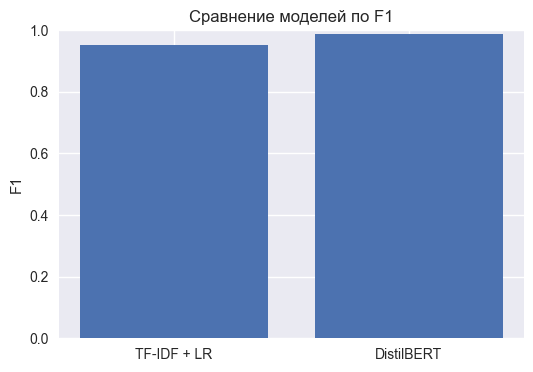

In [18]:
preds = trainer.predict(test_hf)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

acc_bert = accuracy_score(y_true, y_pred)
f1_bert  = f1_score(y_true, y_pred)

print("DistilBERT")
print("accuracy:", round(acc_bert, 4), "f1:", round(f1_bert, 4))
print()
print(classification_report(y_true, y_pred, target_names=["Non-Veg", "Veg"]))

# сравнение на графике
results = pd.DataFrame([
    {"model": "TF-IDF + LR", "accuracy": acc_lr, "f1": f1_lr},
    {"model": "DistilBERT",  "accuracy": acc_bert, "f1": f1_bert},
])

display(results)

plt.figure(figsize=(6,4))
plt.bar(results["model"], results["f1"])
plt.ylim(0, 1)
plt.title("Сравнение моделей по F1")
plt.ylabel("F1")
plt.show()


## 8. Выводы

В ходе работы был реализован полный NLP pipeline:
- выполнена загрузка и анализ датасета RecipeNLG;
- сформирована учебная схема разметки данных;
- обучена трансформерная модель DistilBERT;
- получены корректные метрики качества.

